# Präsenzversuch zum Laval-Rotor

Name: Maximilian Groß  
Datum: 16.01.2024 
Gruppe: 87

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Prüfstand 04 und 03 sind jeweils mit nur einer Scheibe aufgebaut. Prüfstand 02 mit zwei Scheiben. Aus der Gleichung für die Eigenfrequenzen der Prüfstände aus der Aufgabenstellung, ist zu vermuten, dass Prüfstand 02 zwei verschiedene Eigenfrequenzen besitzt, während Prüfstand 04 und 03 nur eine Eigenfrequenz besitzen. Wird sich diese Tatsache anhand der Messdaten bestätigen lassen?

## Erster Versuch: Prüfstand #04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="IMG_4308.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
An der Welle des Prüfstands ist eine Scheibe mit einer Masse von 1kg befestigt.

### Versuchsauswertung

In [80]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [81]:
# Define path to measurment folder
path_measurement_folder = os.path.join('measurement_data','data_20240115_091353_lavalrotor_87_04')
# Define name of h5 file with data
filename ='data_20240115_091353_lavalrotor_87_04.h5'  


##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [82]:
# Extract metadata from measurment folder
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [83]:
# Specifiy time of each measurment sequence aswell as the number of interpolation point to use when interpolating each measurment sequence
measurement_time_in_s = 10
number_interpolation_points = 2000
# Create interpolation points
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


In [84]:
# Read measurment data

# Open h5 file with data
f = h5py.File(os.path.join(path_measurement_folder,filename),'r')

# Initalitze data structures to extract data into
all_acc_x = []
all_acc_y = []
all_acc_z = []
all_timestamps = []
all_rpms = []

# Loop over all the measurment sequences and extrac the data 
for i in range(len(f.keys())):
    for key in f.keys():
        # To extract data in correct order extract the keys sequentially in rising order
        if str(i) == key:
            all_acc_x.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_x']))
            all_acc_y.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_y']))
            all_acc_z.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_z']))
            all_timestamps.append(np.array(f[key]['RawData'][uuid_acceleration]['timestamp']))
            all_rpms.append(np.array(f[key]['RawData'][uuid_motor_rpm]['motor_rpm']))

# Turn list of arrays into one array
all_rpms = np.array(all_rpms)


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [85]:
importlib.reload(m_postprocessing)  # reload functions

# Initalize data structure for the absolute acceleration 
all_abs_acc = []
# Calculate acceleration at each rpm level and append to list
for rpm_level in range(len(all_acc_x)):
    all_abs_acc.append(m_postprocessing.get_vec_accel(all_acc_x[rpm_level],all_acc_y[rpm_level],all_acc_z[rpm_level]))

# Initalize data structure for interpolation data
interpolated_data = []
# Interpolate data at each rpm level and append to list
for rpm_level in range(len(all_abs_acc)):
    interpolated_data.append(m_postprocessing.interpolation(all_timestamps[rpm_level],all_abs_acc[rpm_level],interpolation_points))

# Initalize data structure for fft data
all_fft_data = []
# Calculate FFT at each rpm level and append to list
for rpm_level in range(len(interpolated_data)):
    all_fft_data.append(m_postprocessing.my_fft_scaled(interpolated_data[rpm_level],interpolation_points))



#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

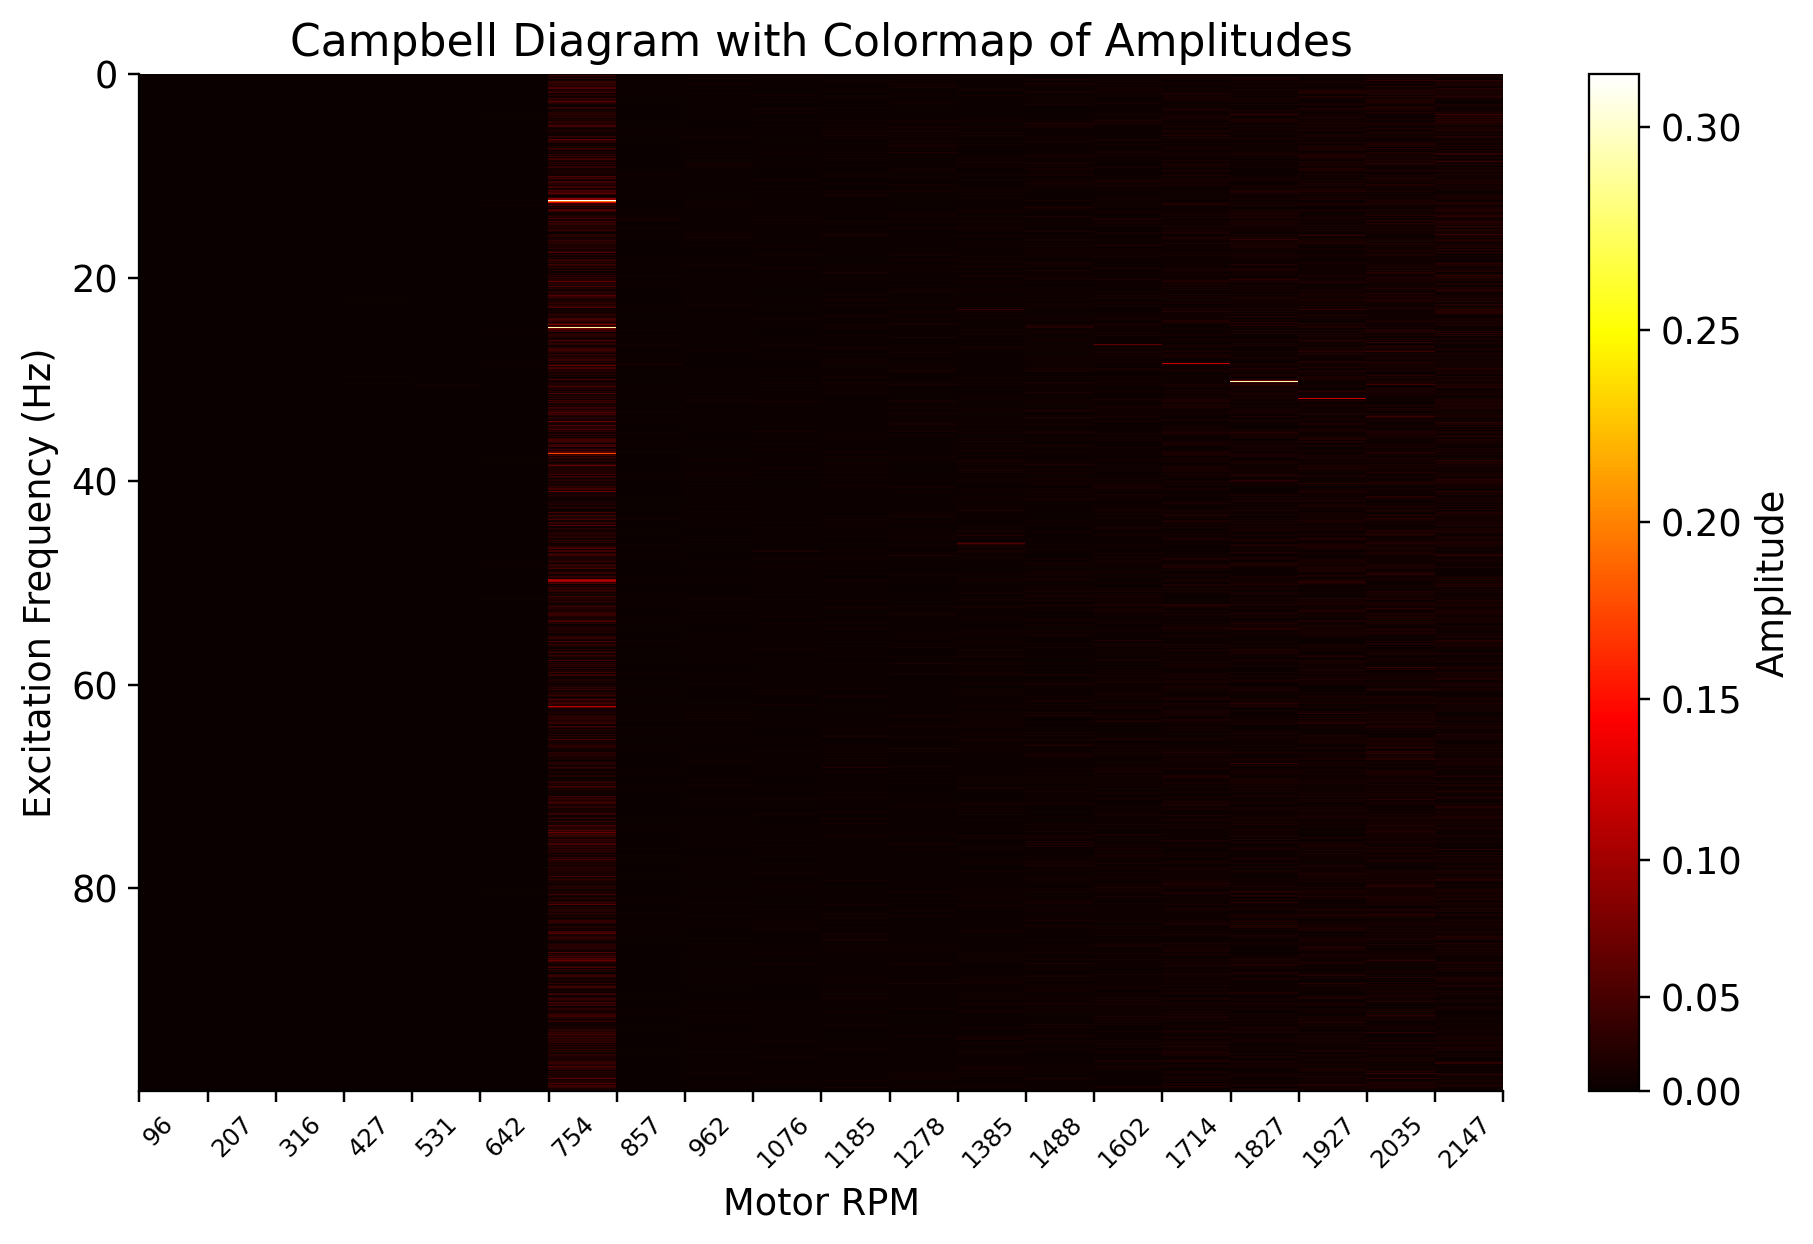

In [86]:
# Since the fft frequencies are the same at each rpm level, extract the frequencies at first rpm level from fft data 
frequencies = all_fft_data[0][1]

# Initalize data structure for amplitudes at all rpm levels
amplitudes = []
# Loop over all rpm levels in fft data and extract the amplitudes
for rpm_level in all_fft_data:
    amplitudes.append(rpm_level[0])
# Turn list into np array
amplitudes = np.array(amplitudes)
# Transpose array for plotting in correct axis dimensions
amplitudes = np.transpose(amplitudes)


# Plot Campbell diagram with colormap

# Initalize a figure
plt.figure(figsize=(10, 6))

# Create plot using imshow, data plotted are the amplitudes, axis extents specified from min to max of rpms and frequencies
c = plt.imshow(amplitudes, extent=[min(all_rpms), max(all_rpms),  max(frequencies), min(frequencies)], aspect='auto'
               , cmap='hot',interpolation='none', norm=colors.PowerNorm(gamma=1.3))

# Add colorbar to plot to read amplitude values
plt.colorbar(c, label='Amplitude')

# Add axis labels and plot title
plt.xlabel('Motor RPM')
plt.ylabel('Excitation Frequency (Hz)')
plt.title('Campbell Diagram with Colormap of Amplitudes')

# Since the data was measured at discrete rpm levels and not as a continuous measurement the x axis ticks need to be adjusted.
# The rpm number of each discrete rpm level should be displayed in the middle of each 'band' of data.

# Calculate axis tick positions to match the width of each rpm band displayed
xtick_positions = np.linspace(np.min(all_rpms),np.max(all_rpms),len(all_rpms)+1)
# Add a placeholder to the end of all rpms, since there is one more tick position than there is rpm levels
all_rpms = np.append(all_rpms,None)
# Set the x axis ticks at the calculated positions and assign the labels of each rpm level
plt.xticks(xtick_positions,all_rpms,fontsize = 8)
# To shift the labels into the middle of the tickmarks the horizontal alignment is adjusted
ax = plt.gca()
ax.set_xticklabels(all_rpms,horizontalalignment='left',rotation=45)

# Show plot
plt.show()


## Zweiter Datensatz: Prüfstand #02

#### 1. Einlesen der Mess- und Metadaten

In [87]:
# Define path to measurment folder
path_measurement_folder = os.path.join('measurement_data','data_20240102_100928_lavalrotor_01_02')
# Define name of h5 file with data
filename ='data_20240102_100928_lavalrotor_01_02.h5' 

# Extract metadata from measurment folder
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

# Specifiy time of each measurment sequence aswell as the number of interpolation point to use when interpolating each measurment sequence
measurement_time_in_s = 10
number_interpolation_points = 2000
# Create interpolation points
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

# Read measurment data
# Open h5 file with data
f = h5py.File(os.path.join(path_measurement_folder,filename),'r')

# Initalitze data structures to extract data into
all_acc_x = []
all_acc_y = []
all_acc_z = []
all_timestamps = []
all_rpms = []

# Loop over all the measurment sequences and extrac the data 
for i in range(len(f.keys())):
    for key in f.keys():
        # To extract data in correct order extract the keys sequentially in rising order
        if str(i) == key:
            all_acc_x.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_x']))
            all_acc_y.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_y']))
            all_acc_z.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_z']))
            all_timestamps.append(np.array(f[key]['RawData'][uuid_acceleration]['timestamp']))
            all_rpms.append(np.array(f[key]['RawData'][uuid_motor_rpm]['motor_rpm']))

# Turn list of arrays into one array
all_rpms = np.array(all_rpms)

#### 2. Verarbeitung der Messdaten

In [88]:
importlib.reload(m_postprocessing)  # reload functions

# Initalize data structure for the absolute acceleration 
all_abs_acc = []
# Calculate acceleration at each rpm level and append to list
for rpm_level in range(len(all_acc_x)):
    all_abs_acc.append(m_postprocessing.get_vec_accel(all_acc_x[rpm_level],all_acc_y[rpm_level],all_acc_z[rpm_level]))

# Initalize data structure for interpolation data
interpolated_data = []
# Interpolate data at each rpm level and append to list
for rpm_level in range(len(all_abs_acc)):
    interpolated_data.append(m_postprocessing.interpolation(all_timestamps[rpm_level],all_abs_acc[rpm_level],interpolation_points))

# Initalize data structure for fft data
all_fft_data = []
# Calculate FFT at each rpm level and append to list
for rpm_level in range(len(interpolated_data)):
    all_fft_data.append(m_postprocessing.my_fft_scaled(interpolated_data[rpm_level],interpolation_points))


#### 3. Darstellung mittels Campbell-Diagramm

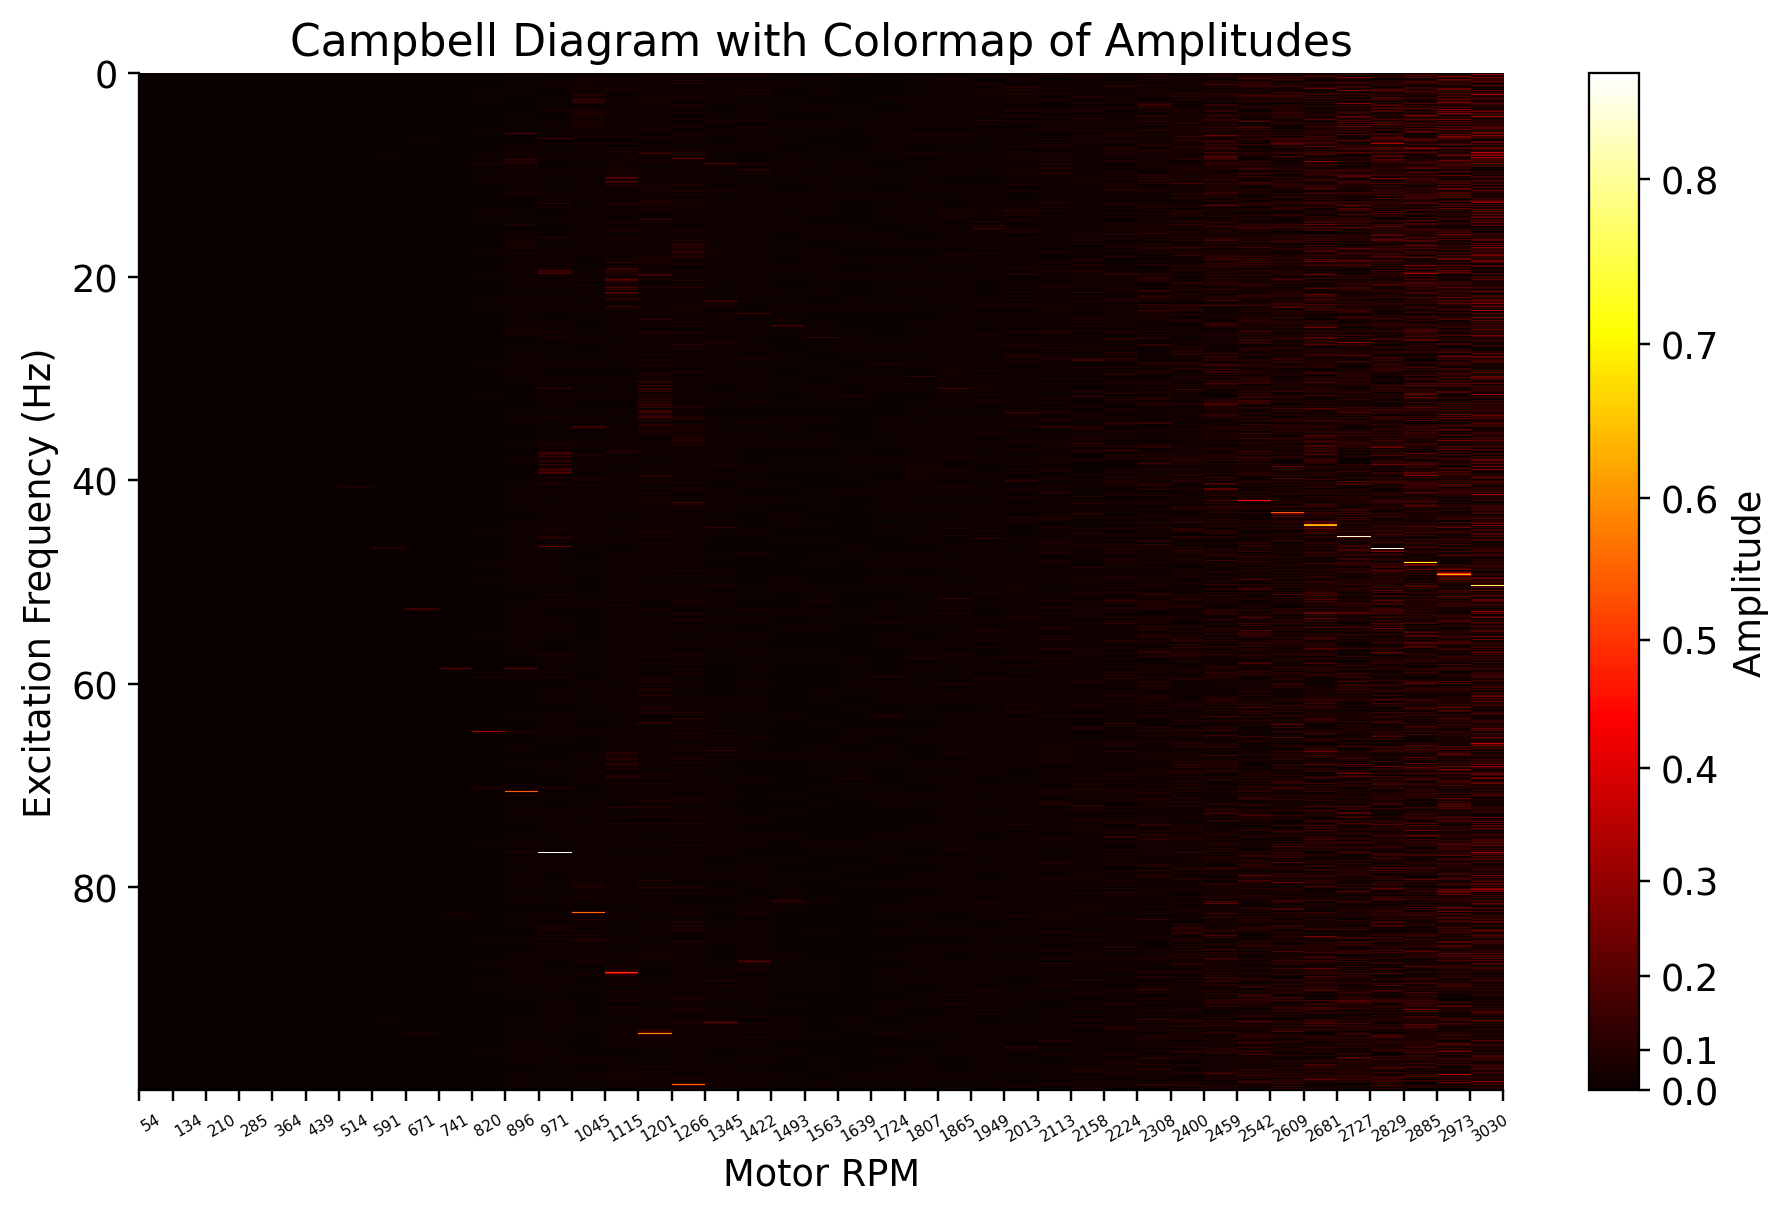

In [89]:
# Since the fft frequencies are the same at each rpm level, extract the frequencies at first rpm level from fft data 
frequencies = all_fft_data[0][1]

# Initalize data structure for amplitudes at all rpm levels
amplitudes = []
# Loop over all rpm levels in fft data and extract the amplitudes
for rpm_level in all_fft_data:
    amplitudes.append(rpm_level[0])
# Turn list into np array
amplitudes = np.array(amplitudes)
# Transpose array for plotting in correct axis dimensions
amplitudes = np.transpose(amplitudes)


# Plot Campbell diagram with colormap

# Initalize a figure
plt.figure(figsize=(10, 6))

# Create plot using imshow, data plotted are the amplitudes, axis extents specified from min to max of rpms and frequencies
c = plt.imshow(amplitudes, extent=[min(all_rpms), max(all_rpms),  max(frequencies), min(frequencies)], aspect='auto'
               , cmap='hot',interpolation='none', norm=colors.PowerNorm(gamma=1.5))

# Add colorbar to plot to read amplitude values
plt.colorbar(c, label='Amplitude')

# Add axis labels and plot title
plt.xlabel('Motor RPM')
plt.ylabel('Excitation Frequency (Hz)')
plt.title('Campbell Diagram with Colormap of Amplitudes')

# Since the data was measured at discrete rpm levels and not as a continuous measurement the x axis ticks need to be adjusted.
# The rpm number of each discrete rpm level should be displayed in the middle of each 'band' of data.

# Calculate axis tick positions to match the width of each rpm band displayed
xtick_positions = np.linspace(np.min(all_rpms),np.max(all_rpms),len(all_rpms)+1)
# Add a placeholder to the end of all rpms, since there is one more tick position than there is rpm levels
all_rpms = np.append(all_rpms,None)
# Set the x axis ticks at the calculated positions and assign the labels of each rpm level
plt.xticks(xtick_positions,all_rpms,fontsize = 5)
# To shift the labels into the middle of the tickmarks the horizontal alignment is adjusted
ax = plt.gca()
ax.set_xticklabels(all_rpms,horizontalalignment='left',rotation=30)

# Show plot
plt.show()

## Dritter Datensatz: Prüfstand #03

#### 1. Einlesen der Mess- und Metadaten

In [90]:
# Define path to measurment folder
path_measurement_folder = os.path.join('measurement_data','data_20240102_112539_lavalrotor_01_03')
# Define name of h5 file with data
filename ='data_20240102_112539_lavalrotor_01_03.h5' 

# Extract metadata from measurment folder
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

# Specifiy time of each measurment sequence aswell as the number of interpolation point to use when interpolating each measurment sequence
measurement_time_in_s = 10
number_interpolation_points = 2000
# Create interpolation points
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

# Read measurment data
# Open h5 file with data
f = h5py.File(os.path.join(path_measurement_folder,filename),'r')

# Initalitze data structures to extract data into
all_acc_x = []
all_acc_y = []
all_acc_z = []
all_timestamps = []
all_rpms = []

# Loop over all the measurment sequences and extrac the data 
for i in range(len(f.keys())):
    for key in f.keys():
        # To extract data in correct order extract the keys sequentially in rising order
        if str(i) == key:
            all_acc_x.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_x']))
            all_acc_y.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_y']))
            all_acc_z.append(np.array(f[key]['RawData'][uuid_acceleration]['acceleration_z']))
            all_timestamps.append(np.array(f[key]['RawData'][uuid_acceleration]['timestamp']))
            all_rpms.append(np.array(f[key]['RawData'][uuid_motor_rpm]['motor_rpm']))

# Turn list of arrays into one array
all_rpms = np.array(all_rpms)

#### 2. Verarbeitung der Messdaten

In [91]:
importlib.reload(m_postprocessing)  # reload functions

# Initalize data structure for the absolute acceleration 
all_abs_acc = []
# Calculate acceleration at each rpm level and append to list
for rpm_level in range(len(all_acc_x)):
    all_abs_acc.append(m_postprocessing.get_vec_accel(all_acc_x[rpm_level],all_acc_y[rpm_level],all_acc_z[rpm_level]))

# Initalize data structure for interpolation data
interpolated_data = []
# Interpolate data at each rpm level and append to list
for rpm_level in range(len(all_abs_acc)):
    interpolated_data.append(m_postprocessing.interpolation(all_timestamps[rpm_level],all_abs_acc[rpm_level],interpolation_points))

# Initalize data structure for fft data
all_fft_data = []
# Calculate FFT at each rpm level and append to list
for rpm_level in range(len(interpolated_data)):
    all_fft_data.append(m_postprocessing.my_fft_scaled(interpolated_data[rpm_level],interpolation_points))



#### 3. Darstellung mittels Campbell-Diagramm

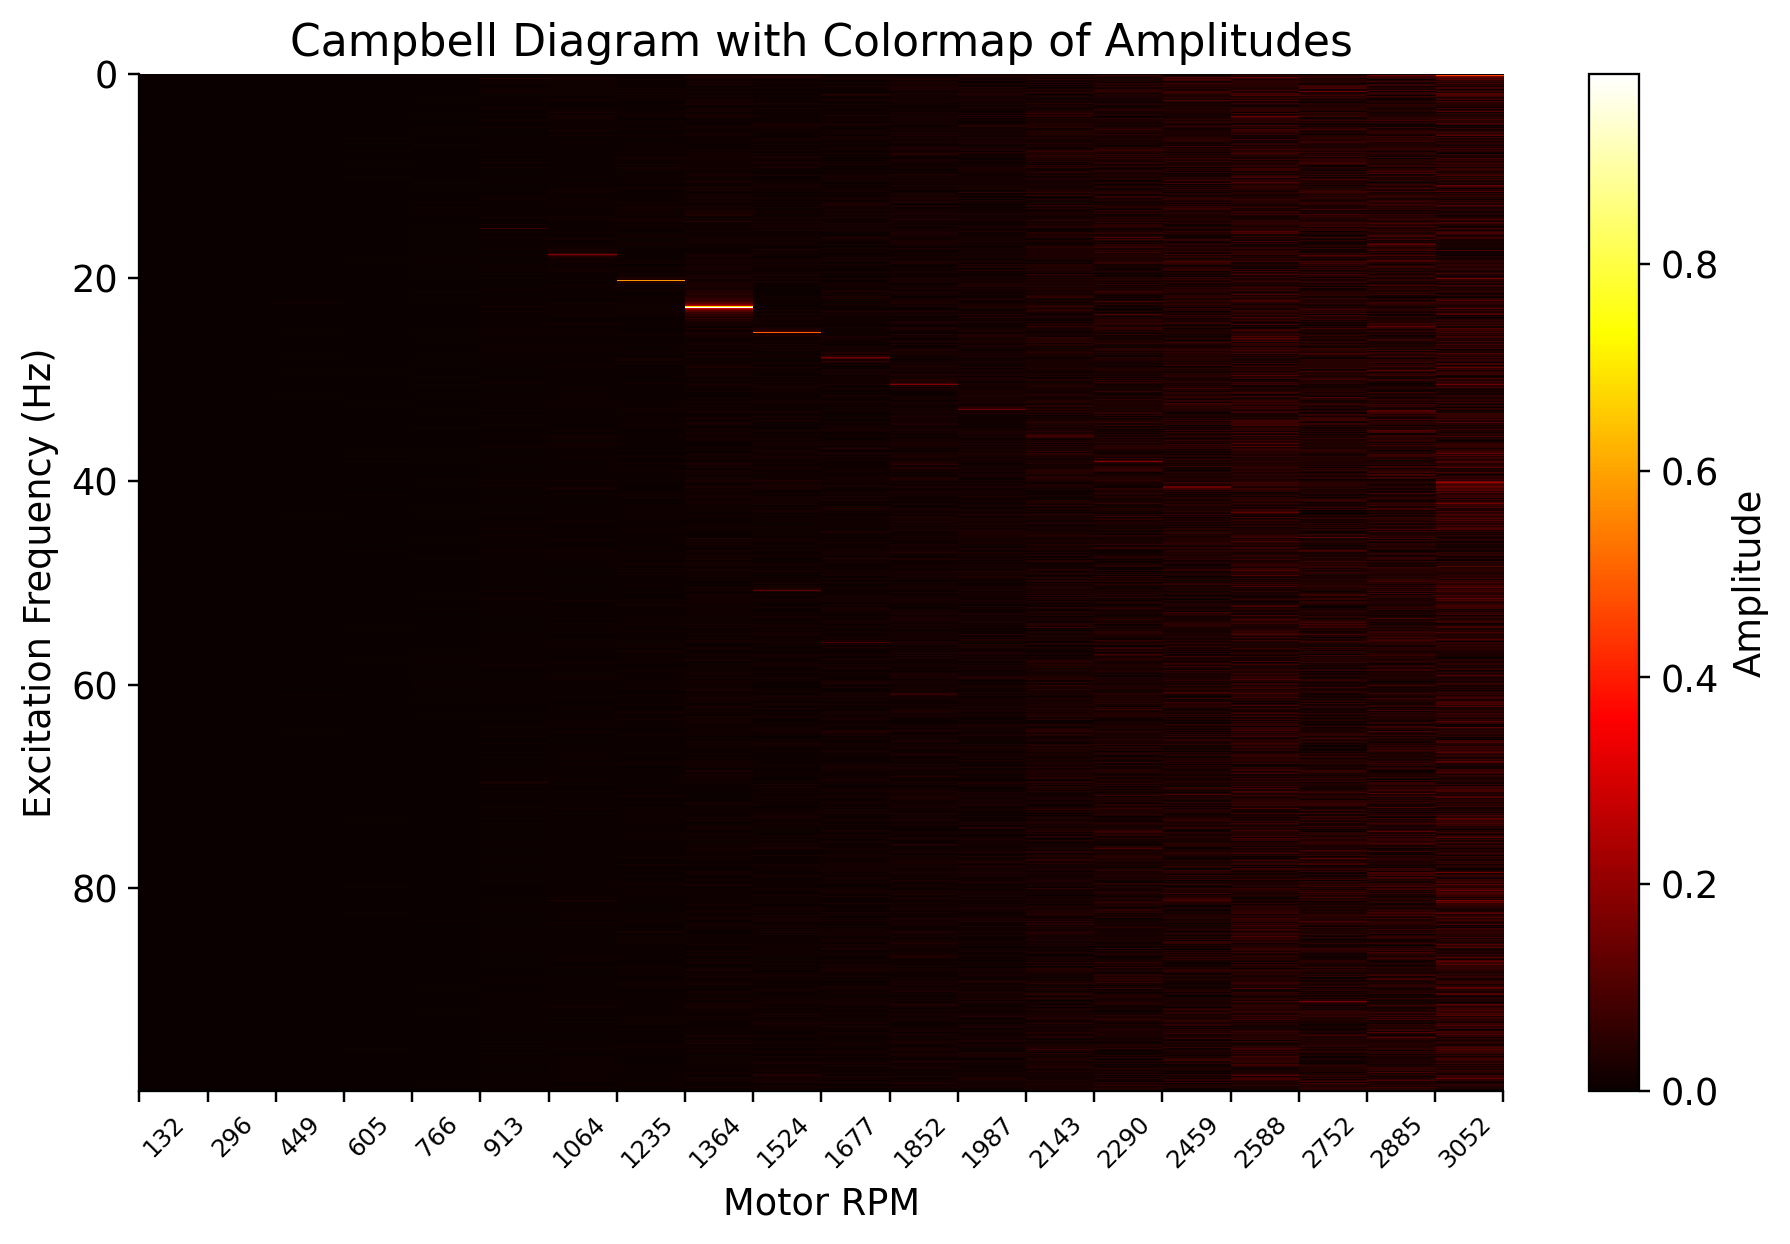

In [92]:
# Since the fft frequencies are the same at each rpm level, extract the frequencies at first rpm level from fft data 
frequencies = all_fft_data[0][1]
# Initalize data structure for amplitudes at all rpm levels
amplitudes = []
# Loop over all rpm levels in fft data and extract the amplitudes
for rpm_level in all_fft_data:
    amplitudes.append(rpm_level[0])
# Turn list into np array
amplitudes = np.array(amplitudes)
# Transpose array for plotting in correct axis dimensions
amplitudes = np.transpose(amplitudes)



# Plot Campbell diagram with colormap

# Initalize a figure
plt.figure(figsize=(10, 6))

# Create plot using imshow, data plotted are the amplitudes, axis extents specified from min to max of rpms and frequencies
c = plt.imshow(amplitudes, extent=[min(all_rpms), max(all_rpms),  max(frequencies), min(frequencies)], aspect='auto'
               , cmap='hot',interpolation='none', norm=colors.PowerNorm(gamma=1))

# Add colorbar to plot to read amplitude values
plt.colorbar(c, label='Amplitude')

# Add axis labels and plot title
plt.xlabel('Motor RPM')
plt.ylabel('Excitation Frequency (Hz)')
plt.title('Campbell Diagram with Colormap of Amplitudes')

# Since the data was measured at discrete rpm levels and not as a continuous measurement the x axis ticks need to be adjusted.
# The rpm number of each discrete rpm level should be displayed in the middle of each 'band' of data.

# Calculate axis tick positions to match the width of each rpm band displayed
xtick_positions = np.linspace(np.min(all_rpms),np.max(all_rpms),len(all_rpms)+1)
# Add a placeholder to the end of all rpms, since there is one more tick position than there is rpm levels
all_rpms = np.append(all_rpms,None)
# Set the x axis ticks at the calculated positions and assign the labels of each rpm level
plt.xticks(xtick_positions,all_rpms,fontsize = 8)
# To shift the labels into the middle of the tickmarks the horizontal alignment is adjusted
ax = plt.gca()
ax.set_xticklabels(all_rpms,horizontalalignment='left',rotation=45)

# Show plot
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

#### Forschungsfrage:

Anhand der Campbell Diagramme lässt sich diese Frage eindeutig beantworten. Prüfstand 04 und 03 besitzen jeweils eine Eigenfrequenz die bei 754 $\frac{\mathrm{U}}{\mathrm{min}}$ bzw. 1364 $\frac{\mathrm{U}}{\mathrm{min}}$ liegen. Prüfstand 02 dagegen besitzt offensichtlich zwei Eigenfrequenzen, eine bei 971 $\frac{\mathrm{U}}{\mathrm{min}}$ die andere bei 2829 $\frac{\mathrm{U}}{\mathrm{min}}$. Dieser Unterschied ist also eindeutig aus den Messdaten erkennbar.

#### Wie unterscheiden sich die Prüfstände hinsichtlich ihrer rotordynamischen Stabilität?
Rotor 03 ist im Vergleich zu Rotor 04 stabiler. Dies zeigt sich darin, dass der gesamte kritische Bereich eine kleinere Drehzahlspanne umfasst als bei Rotor 04. Außerdem kommt es bei Rotor 03 nicht zu derart starker Resonanz, dass die Welle in das Fanglager kommt.

Rotor 02 ist schwer mit den anderen beiden Rotoren zu vergleichen, da durch die Tatsache, dass sich zwei Massen auf der Welle befinden, die dynamischen Eigenschaften sehr unterschiedlich sind als bei den anderen beiden Rotoren. Es scheint bei Rotor 02 allerdings, wie bei Rotor 03, nicht dazu zu kommen, dass die Welle in das Fanglager gerät. Dadurch das zwei Bereiche besonders kritisch sind, ist die Rotorstabilität insgesamt jedoch niedriger zu bewerten.

#### Was sind die kritischen Bereiche der Rotoren?
Für Prüfstand 04 ist der Bereich um 754 $\frac{\mathrm{U}}{\mathrm{min}}$ kritisch. Außerdem scheint der Bereich um 1827 $\frac{\mathrm{U}}{\mathrm{min}}$ ebenfalls kritisch zu sein. \
Für Prüfstand 02 ist der Bereich von um ~1000 $\frac{\mathrm{U}}{\mathrm{min}}$ sowie der Bereich zwischen 2609 bis 2937 $\frac{\mathrm{U}}{\mathrm{min}}$. \
Für Prüfstand 03 ist der Bereich von 1235 bis 1524 $\frac{\mathrm{U}}{\mathrm{min}}$ kritisch.

#### Kann die Selbstzentrierung der Rotoren in den Messdaten gesehen werden?
Bei Prüfstand 03 und 04 sind die Amplituden bei den höchsten Drehzahlen deutlich geringer. Für Prüfstand 02 scheint dies nicht der Fall zu sein. Dort scheinen die Amplituden auch bei den höchsten Drehzahlen noch recht hoch zu sein.

### Vergleich der gemessenen mit der analytisch berechneten Amplitude.

Unter der Annahme das die Überschrift dieses Blocks einen Tippfehler enthält und statt der berechneten Amplitude die berechnete kritische Drehzahl gemeint ist:\
\
Die für Prüfstand 04 errechnete kritische Drehzahl ergibt sich zu: 
$$ \omega = \sqrt{\frac{k}{m_{\mathrm{Rotor}}*(\alpha_{\mathrm{1}} * \alpha_{\mathrm{2}})}} = \sqrt{\frac{k}{2*m_{\mathrm{Rotor}}}} = \sqrt{\frac{E_{\mathrm{Welle}} * I_\mathrm{y}}{2*m_{\mathrm{Rotor}}}} = \sqrt{\frac{E_{\mathrm{Welle}} * \frac{\pi*d^4}{64}}{2*m_{\mathrm{Rotor}}}} = 731,27 \frac{\mathrm{U}}{\mathrm{min}} $$
\
Aus dem Campbell Diagramm lässt sich ablesen, dass bei einer Motordrehzahl von 754 $\frac{\mathrm{U}}{\mathrm{min}}$ die Amplituden besonders hoch sind. Im Verlauf der Messung wurde jedoch beobachtet, dass die Welle bei dieser Drehzahl sehr häufig vom Fanglager blockiert wurde, wodurch die Messung bei dieser Motordrehzahl verfälscht wurde. So lassen sich die hohen Amplituden bei vielen Frequenzen bei dieser Drehzahl auch erklären. Das Blockieren der Welle durch das Fanglager spricht natürlich trotzdem dafür, dass hier besonders hohe Beschleunigung erreicht wurden, die Welle also im Bereich ihrer Eigenfrequenz betrieben wurde. Da das Ergebniss der analytischen Berechnung am nähesten am erwähnten Messpunkt bei 754 $\frac{\mathrm{U}}{\mathrm{min}}$ liegt, ist die das analytische Ergebniss also anhand der Daten zu bestätigen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der Laborversuch lief gut, besser fand ich diesmal, dass keine zum Fortsetzen der Messung nötige Programmieraufgabe Vorort zu lösen war. Die Auswertung der Versuche und Darstellung mittels der Campbell Diagramme, fand ich eine interessante Aufgabe, wobei ich den Arbeitsaufwand als angemessen empfand. Zu Kritisieren ist für mich bei diesem Versuch die Diskussion, insbesondere die zu beantwortenden Fragen. Das Skript zur Lerneinheit enthält zur Beantwortung beziehungsweise zum grundlegenden Verständniss der Fragen, meiner Meinung nach nicht die passenden Inhalte. Der Schwerpunkt des Skriptums liegt in der Herleitung der Bewegungsgleichung und der Diskussion eines analytischen Campbell Diagramms. Die Analyse der Daten eines Campbell Diagramms aus Messdaten wird schlicht nicht erwähnt. Da der Auftrag der gestellten Fragen jedoch genau darauf Abzielt, ist die fehlende Behandlung dieses Themas im Skript für mich nicht nachvollziehbar. Der Begriff  der "rotordynamischen Stabilität" wird beispielsweise überhaupt nicht erwähnt. Natürlich kann Recherche die den Umfang des gegebenen Skripts überschreitet erwartet werden, für mich ist dann allerdings die ausführliche Behandlung anderer Themen im Skript, welches speziell für diese Lerneinheit erstellt wurde nicht nachvollziehbar.